## Splink deduplication demo 

In this demo we de-duplicate a dataset.  The dataset is small (1000) rows to enable the tutorial to be run interactively, but readers should imaging the true dataset is large (millions of rows).

This is a comprehensive example in which we demonstrate the full range of functionality of Splink, and how it is intended to be used.  A quickstart notebook is provided elsewhere.

Note that various outputs are printed interactively using e.g. `spark_dataframe.show()`.  This is for instructional purposes only - it degrades performance and shouldn't be used in a production setting.

## Step 1:  Imports and setup

The following is just boilerplate code that sets up the Spark session and sets some other non-essential configuration options

In [1]:
import pandas as pd 
pd.options.display.max_columns = 500
pd.options.display.max_rows = 100

In [2]:
import logging 
logging.basicConfig()  # Means logs will print in Jupyter Lab

# Set to DEBUG if you want splink to log the SQL statements it's executing under the hood
logging.getLogger("splink").setLevel(logging.INFO)

In [3]:
from utility_functions.demo_utils import get_spark
spark = get_spark() # See utility_functions/demo_utils.py for how to set up Spark

## Step 2:  Read in data

Note that the `group` column is the truth - rows which share the same value refer to the same person.  In the real world, we wouldn't have this field because this is the truth - the label which Splink is trying to estimate.

In [4]:
df = spark.read.parquet("data/fake_1000.parquet")
df.show(5)

+---------+----------+-------+----------+------+--------------------+-----+
|unique_id|first_name|surname|       dob|  city|               email|group|
+---------+----------+-------+----------+------+--------------------+-----+
|        0|    Julia |   null|2015-10-29|London| hannah88@powers.com|    0|
|        1|    Julia | Taylor|2015-07-31|London| hannah88@powers.com|    0|
|        2|    Julia | Taylor|2016-01-27|London| hannah88@powers.com|    0|
|        3|    Julia | Taylor|2015-10-29|  null|  hannah88opowersc@m|    0|
|        4|      oNah| Watson|2008-03-23|Bolton|matthew78@ballard...|    1|
+---------+----------+-------+----------+------+--------------------+-----+
only showing top 5 rows



## Step 3:  Profile the data

Understanding your data through the use of summary statistics is critical. 

For the purposes of data linking, one of the most important attributes of your data is cardinality.  Fields like date of birth which have a large number of unique values (high cardinality) are more useful than fields with low cardinality like gender.

Another important attribute is skew, which can occur:
- because values (like a first name of John) occur more frequently in the real world
- due to data quality issues (such as a large number of date of birth fields containing the value '1970-01-01' due errors in date parsing)

In general Splink will produce less accurate predictions when you have skew, especially in the case of extreme skew.  So, for example, different name frequences (John vs Robin) shouldn't cause a huge problem, but if you have 30,000 distinct dates of birth, but half of the values are '1970-01-01' Splink is unlikely to produce accuate predictions of match probability.

It is imperative, therefore, that data quality issues are addressed prior to using Splink.  Note that Splink will correctly deal with nulls, so suspicious values should usually be nulled out.

Splink provides a profiling tool to for you to visually inspect value frequencies, which we can see as follows:

In the caes of our test dataset, there is a moderate level of skew, partcularly on the first_name, surname and city columns.  We can see most of our fields have high cardinality.

We also observe that misspellings are common across most fields.

In [5]:
from splink.profile import column_value_frequencies_chart

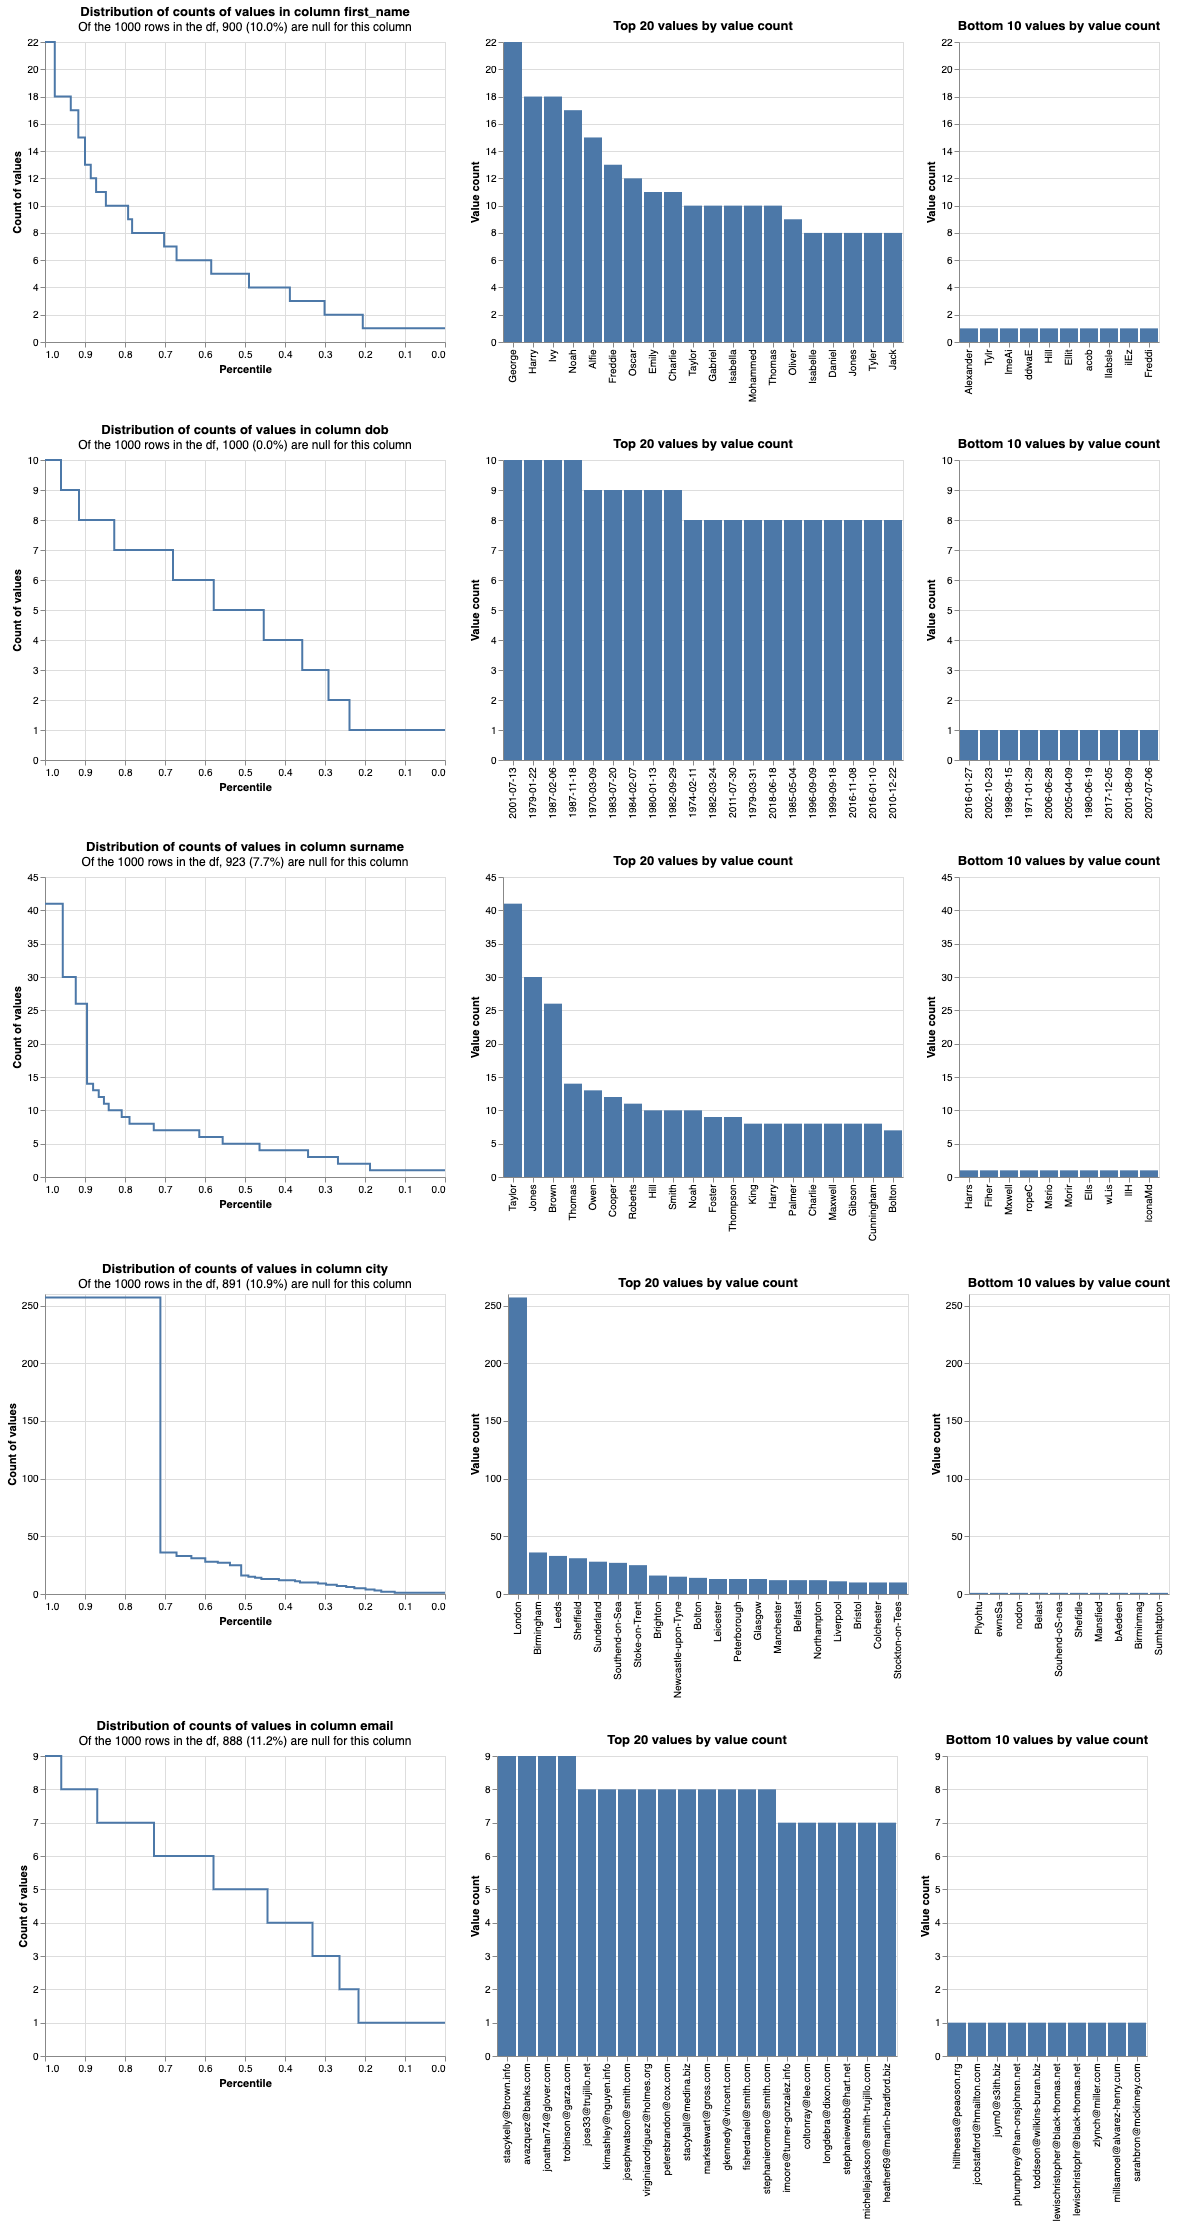

In [6]:
import altair as alt
alt.renderers.enable('mimetype')
column_value_frequencies_chart(['first_name', "surname", "dob", "city", "email"], df, spark)

In this step, with real world data, we would do quite a bit of data cleaning work to do things like standarise names (eg. making them all upper case, splitting out multiple names), cleaning up dates, etc.  Some useful functions are available in `[splink_data_standardisation](https://github.com/moj-analytical-services/splink_data_standardisation)`

This will be different for every dataset, but the aim is to make it as easy as possible for Splink to spot similarities and difference between fields.

Now that we understand the data, we are ready to start using Splink.

## Step 3: Decide on a blocking approach

In most large datasets, it will be computationally intractable to compare every row with every other row.  We can use a technique called blocking to dramatically reduce the number of comparisons by comparing only records that adhere to certain rules, such as that the first name and date of birth must be equal .  Blocking is described further [here](https://toolkit.data.gov.au/Data_Linking_Information_Series_Sheet_4:_Probabilistic_linking.html).

The above profling charts are useful to understand which blocking rules may be effective.  For example, we can see that that the forename 'George' is the most prevalant in the dataset, occurring 22 times.  If we block on forename, $\frac{n\left(n-1\right)}2$ comparisons will be generated amongst Georges, with each instance being compared to each other.  This is probably viable in terms of the number of comparisons generated.  On the other hand, London appears over 250 times, and so blocking on city would generate a very large number of comparisons where both records had city = London.  

Whilst blocking this is useful in reducing record comparisons, the problem is that its rare to find a blocking rule which eliminates enough record comparisons, and does not eliminate true matches (i.e. which has perfect recall).  

The solution to this problem is generally to use several different blocking rules -s o for example, to generate record comparisons based on either the rule that first name must be equal, or that surname must be equal.  This means that the blocking approach will only eliminate true comparisons when both first and surname match, which will happen much less often than either one individually.

Unfortuantely, it is theoretically invalid to estimate the Fellegi Sunter model on comparisons generated from multiple blocking rules, becauase it breaks the assumption of conditional independece.

The recommended approach is to estimate different models, one for each blocking rule, and combine the results. 

We will demonstrate how to combined models in a separate notebook.  In this notebook we demonstrate how to run the model for a single rule

## Step 4:  Configure splink using the `settings` object

`splink` configuration options are stored in a settings dictionary.  This dictionary allows significant customisation, and can therefore get quite complex.  

💥 We provide an tool for helping to author valid settings dictionaries, which includes tooltips and autocomplete, which you can find [here](http://robinlinacre.com/splink_settings_editor/).

Customisation overrides default values built into splink.  For the purposes of this demo, we will specify a simple settings dictionary, which means we will be relying on these sensible defaults.

To help with authoring and validation of the settings dictionary, we have written a [json schema](https://json-schema.org/), which can be found [here](https://github.com/moj-analytical-services/splink/blob/master/splink/files/settings_jsonschema.json).  




In [7]:
settings = {
    "link_type": "dedupe_only",
    "blocking_rules": [
        "l.first_name = r.first_name"
    ],
    "comparison_columns": [
        {
            "col_name": "surname",
            "num_levels": 3,
            "term_frequency_adjustments": True
        },
        {
            "col_name": "dob"
        },
        {
            "col_name": "city",
            "term_frequency_adjustments": True
        },
        {
            "col_name": "email"
        }
    ],
    "additional_columns_to_retain": ["group"],
    "em_convergence": 0.01
}

In words, this setting dictionary says:
- We are performing a deduplication task (the other options are `link_only`, or `link_and_dedupe`)
- We are going generate comparisons subject to the blocking rules contained in the specified array - in this case, only generate comparisons where the forename matches
- When comparing records, we will use information from the `surname`, `dob`, `city` and `email` columns to compute a match score.
- For `surname` string comparison will have three levels:
    - Level 2: Strings are (almost) exactly the same
    - Level 1: Strings are similar 
    - Level 0: No match
- We will make adjustments for term frequencies on the `surname` columns
- We will retain the `group` column in the results even though this is not used as part of comparisons.  This is a labelled dataset and `group` contains the true match - i.e. where group matches, the records pertain to the same person
- Consider the algorithm to have converged when no parameter changes by more than 0.01 between iterations

## Step 3:  Estimate u probabilities directly

The u probabilities are the probabilities that fields will match given the records do not match.  So, for example, a 'month of birth' column would be expected to match around 1/12 of the time amongst non-matching records

For many datasets, the probability that two records selected at random will match is almost zero.  A sample of such pairs of records should therefore almost exclusively contain non-matches.  

We can therefore simply assume this dataset contains non-matches only, and directly estimate u probabilities.


In [8]:
from splink.estimate import estimate_u_values
settings_with_u = estimate_u_values(settings, df, spark, fix_u_probabilities=True)

In [9]:
from pprint import pprint
pprint(settings_with_u)

{'additional_columns_to_retain': ['group'],
 'blocking_rules': ['l.first_name = r.first_name'],
 'comparison_columns': [{'col_name': 'surname',
                         'fix_u_probabilities': True,
                         'num_levels': 3,
                         'term_frequency_adjustments': True,
                         'u_probabilities': [0.989692211151123,
                                             0.0028648446314036846,
                                             0.007442955859005451]},
                        {'col_name': 'dob',
                         'fix_u_probabilities': True,
                         'u_probabilities': [0.9962962865829468,
                                             0.003703703638166189]},
                        {'col_name': 'city',
                         'fix_u_probabilities': True,
                         'term_frequency_adjustments': True,
                         'u_probabilities': [0.906921923160553,
                                          

## Step 4:  Estimate match scores using the Expectation Maximisation algorithm


Columns are assumed to be strings by default.  See the 'comparison vector settings' notebook for details of configuration options.



In [10]:
from splink import Splink

linker = Splink(settings_with_u, df, spark)
df_e = linker.get_scored_comparisons()

INFO:splink.iterate:Iteration 0 complete
INFO:splink.model:The maximum change in parameters was 0.22885468006134035 for key dob, level 1
INFO:splink.iterate:Iteration 1 complete
INFO:splink.model:The maximum change in parameters was 0.06432151794433594 for key dob, level 0
INFO:splink.iterate:Iteration 2 complete
INFO:splink.model:The maximum change in parameters was 0.01809200644493103 for key email, level 0
INFO:splink.iterate:Iteration 3 complete
INFO:splink.model:The maximum change in parameters was 0.0058144330978393555 for key email, level 0
INFO:splink.iterate:EM algorithm has converged


## Step 5: Inspect results 



In [11]:
# Inspect main dataframe that contains the match scores
cols_to_inspect = ["tf_adjusted_match_prob","unique_id_l","unique_id_r","group_l", "group_r", "surname_l","surname_r","dob_l","dob_r","city_l","city_r","email_l","email_r",]

df_e.toPandas()[cols_to_inspect].sort_values(["unique_id_l", "unique_id_r"]).head(10)

,tf_adjusted_match_prob,unique_id_l,unique_id_r,group_l,group_r,surname_l,surname_r,dob_l,dob_r,city_l,city_r,email_l,email_r
2,0.992053,0,1,0,0,None,Taylor,2015-10-29,2015-07-31,London,London,hannah88@powers.com,hannah88@powers.com
1,0.992053,0,2,0,0,None,Taylor,2015-10-29,2016-01-27,London,London,hannah88@powers.com,hannah88@powers.com
0,0.978881,0,3,0,0,None,Taylor,2015-10-29,2015-10-29,London,None,hannah88@powers.com,hannah88opowersc@m
4,0.999916,1,2,0,0,Taylor,Taylor,2015-07-31,2016-01-27,London,London,hannah88@powers.com,hannah88@powers.com
3,0.920980,1,3,0,0,Taylor,Taylor,2015-07-31,2015-10-29,London,None,hannah88@powers.com,hannah88opowersc@m
5,0.920980,2,3,0,0,Taylor,Taylor,2016-01-27,2015-10-29,London,None,hannah88@powers.com,hannah88opowersc@m
21,0.999041,5,7,1,1,Watson,Watson,2008-03-23,2008-02-05,Bolton,tolon,matthew78@ballard-mcdonald.net,matthew78@ballard-mcdonald.net
20,0.997225,5,9,1,1,Watson,Watson,2008-03-23,2008-01-19,Bolton,Bolton,matthew78@ballard-mcdonald.net,None
19,0.981742,5,12,1,1,Watson,None,2008-03-23,2008-03-23,Bolton,Blotn,matthew78@ballard-mcdonald.net,None
18,0.008006,5,97,1,20,Watson,Morris,2008-03-23,1983-07-20,Bolton,Birmingham,matthew78@ballard-mcdonald.net,emilysmith@irwin-medina.biz


We can plot a histogram of the splink match probility.  This chart shows that, for the majority of record comparisons, the match score is estimated to be close to 0 or 1.  This indicates that there are few pairs of records where we are unsure whether it's a match or not.

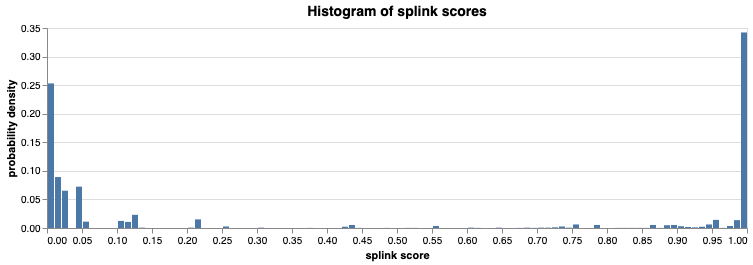

In [12]:
from splink.diagnostics import splink_score_histogram
splink_score_histogram(df_e, spark, 100)

The `params` property of the `linker` is an object that contains a lot of diagnostic information about how the match probability was computed.  The following cells demonstrate some of its functionality

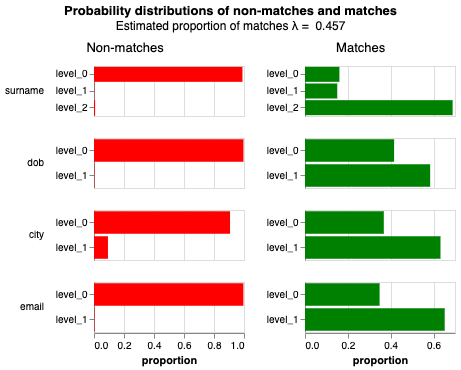

In [13]:
model = linker.model
model.probability_distribution_chart()

An alternative representation of the parameters displays them in terms of the effect different values in the comparison vectors have on the match probability:

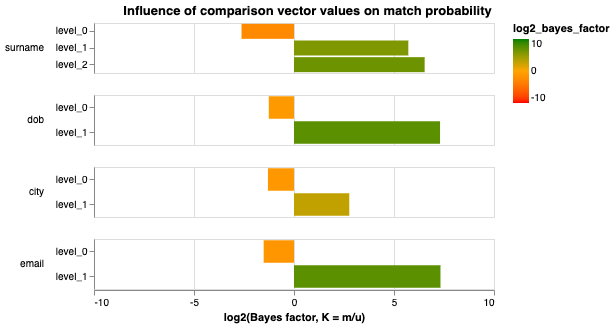

In [14]:
model.bayes_factor_chart()

In [15]:
# If charts aren't displaying correctly in your notebook, you can write them to a file (by default splink_charts.html)
model.all_charts_write_html_file(filename="splink_charts.html", overwrite=True)

You can also generate a report which explains how the match probability was computed for an individual comparison row.  

Note that you need to convert the row to a dictionary for this to work

In [16]:
from splink.intuition import intuition_report

sample = df_e.toPandas().sample(1)
row_dict = sample.to_dict(orient="records")[0]
display(sample)
print(intuition_report(row_dict, model))

,tf_adjusted_match_prob,match_probability,unique_id_l,unique_id_r,surname_l,surname_r,gamma_surname,dob_l,dob_r,gamma_dob,city_l,city_r,gamma_city,email_l,email_r,gamma_email,group_l,group_r
449,0.008006,0.008006,147,730,Taylr,Lawrence,0,2017-11-24,2016-12-25,0,noLdo,Stoke-on-ernt,0,coltonray@lee.com,barbarapace@manning.org,0,26,125



Initial probability of match (prior) = λ = 0.4568
------
Comparison of surname.  Values are:                
surname_l:                                         Taylr
surname_r:                                         Lawrence
Comparison has:                                    3 levels
Level for this comparison:                         gamma_surname = 0
m probability = P(level|match):                    0.1606
u probability = P(level|non-match):                0.9897
Bayes factor = m/u:                                0.1622
New probability of match (updated belief):         0.12

------
Comparison of dob.  Values are:                    
dob_l:                                             2017-11-24
dob_r:                                             2016-12-25
Comparison has:                                    2 levels
Level for this comparison:                         gamma_dob = 0
m probability = P(level|match):                    0.4159
u probability = P(level|non-match):            

## Step 6: Measure accuracy of results 

If you have labelled data, Splink contains routines to compute various accuracy statistics.

The labelled data should look like this:

| unique_id_l | unique_id_r | clerical_match_score |
|:------------|:------------|---------------------:|
| id1         | id2         |                  0.9 |
| id1         | id3         |                  0.1 |

Since we have labelled data, in this noteboko I create this table from the 'group' field of the original data



**Note: We will fine that the overall accuracy of these results is low because our blocking rule eliminates a large percentage of true matches**

In [17]:
cols = ['unique_id', 'group']
dfpd_l = df.toPandas().sample(300)[cols]
dfpd_l["join_col"] = 1
dfpd_r = dfpd_l.copy()
labels = dfpd_l.merge(dfpd_r, on = "join_col", suffixes=('_l', '_r'))
labels = labels[labels["unique_id_r"]< labels["unique_id_l"]]
labels["clerical_match_score"] = (labels["group_l"] == labels["group_r"]).astype(float)
labels = labels.drop(["group_l", "group_r", "join_col"], axis=1)
labels.head()

,unique_id_l,unique_id_r,clerical_match_score
3,527,340,0.0
4,527,158,0.0
8,527,9,0.0
12,527,57,0.0
14,527,221,0.0


In [18]:
from splink.truth import labels_with_splink_scores, roc_chart, precision_recall_chart
labels_sp = spark.createDataFrame(labels)
labels_and_scores = labels_with_splink_scores(labels_sp, df_e, "unique_id", spark)
labels_and_scores.show()

+-----------+-----------+--------------------+----------------------+-----------------+
|unique_id_l|unique_id_r|clerical_match_score|tf_adjusted_match_prob|found_by_blocking|
+-----------+-----------+--------------------+----------------------+-----------------+
|        108|          0|                 0.0|                   0.0|            false|
|        197|          0|                 0.0|                   0.0|            false|
|         24|          0|                 0.0|                   0.0|            false|
|        275|          0|                 0.0|                   0.0|            false|
|        312|          0|                 0.0|                   0.0|            false|
|        324|          0|                 0.0|                   0.0|            false|
|         34|          0|                 0.0|                   0.0|            false|
|        364|          0|                 0.0|                   0.0|            false|
|        378|          0|       

In [19]:
labels_and_scores_pd = labels_and_scores.toPandas()
f1 = labels_and_scores_pd["clerical_match_score"] == 1.0
labels_and_scores_pd[f1].sample(10)

,unique_id_l,unique_id_r,clerical_match_score,tf_adjusted_match_prob,found_by_blocking
19676,6,4,1.0,0.000000,False
26961,671,668,1.0,0.000000,False
43949,691,692,1.0,0.999998,True
41026,252,258,1.0,1.000000,True
42454,462,455,1.0,0.000000,False
14838,507,502,1.0,0.000000,False
44175,749,751,1.0,0.999977,True
16397,794,792,1.0,0.000000,False
39331,976,980,1.0,1.000000,True
28100,0,3,1.0,0.978881,True


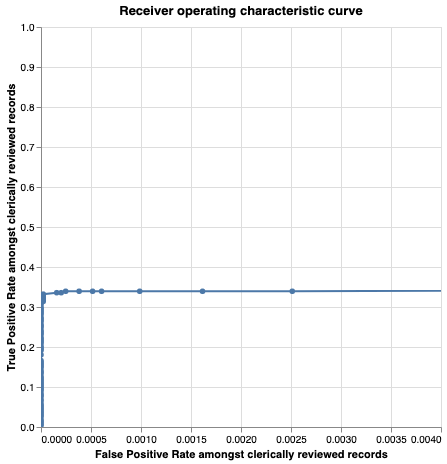

In [20]:
from splink.truth import labels_with_splink_scores, roc_chart, precision_recall_chart


roc_chart(labels_and_scores, spark)

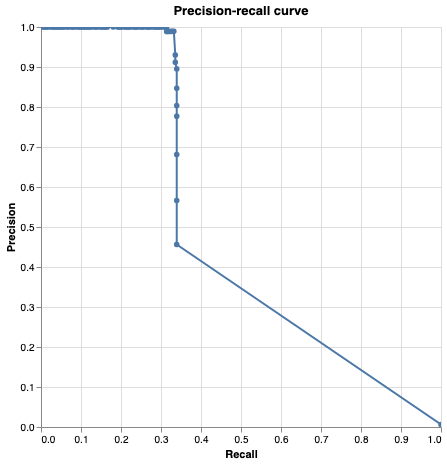

In [21]:
precision_recall_chart(labels_and_scores, spark)

## Step 7: Use graphframes to resolve links into groups

In [22]:
from graphframes import GraphFrame


df_e.createOrReplaceTempView("df_e")
sql = """
select unique_id_l as id
from df_e
union
select unique_id_r as id
from df_e
"""
nodes = spark.sql(sql)

sql = """
select
unique_id_l as src,
unique_id_r as dst,
tf_adjusted_match_prob
from df_e
where tf_adjusted_match_prob > 0.99
"""
edges = spark.sql(sql)

g = GraphFrame(nodes, edges)

cc = g.connectedComponents()

cc.createOrReplaceTempView("cc")
df.createOrReplaceTempView("df")
sql = """
select cc.component as estimated_group, df.*
from cc
left join
df 
on cc.id = df.unique_id
order by group, estimated_group
"""
results = spark.sql(sql)
results.toPandas().head(30)

,estimated_group,unique_id,first_name,surname,dob,city,email,group
0,0,2,Julia,Taylor,2016-01-27,London,hannah88@powers.com,0
1,0,0,Julia,None,2015-10-29,London,hannah88@powers.com,0
2,0,1,Julia,Taylor,2015-07-31,London,hannah88@powers.com,0
3,3,3,Julia,Taylor,2015-10-29,None,hannah88opowersc@m,0
4,5,9,Noah,Watson,2008-01-19,Bolton,None,1
5,5,7,Noah,Watson,2008-02-05,tolon,matthew78@ballard-mcdonald.net,1
6,5,5,Noah,Watson,2008-03-23,Bolton,matthew78@ballard-mcdonald.net,1
7,6,8,Watson,Noah,2008-06-15,Bolton,matthew78@ballard-mcdonald.net,1
8,6,6,Watson,Noah,2008-03-23,None,matthew78@ballard-mcdonald.net,1
9,6,10,Watson,Noah,2008-03-23,Bolton,matthbw78eallard-mcdonald.net,1
